In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import chi2_contingency
import joblib
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/cs-training.csv')
df_tested = pd.read_csv('data/cs-test.csv')

Для начала начнем с пояснения столбцов датафрейма:
- SeriousDlqin2yrs - Человек допустил просрочку платежа на 90 дней или более за последние 2 года
- RevolvingUtilizationOfUnsecuredLines - Общий баланс по кредитным картам и личным кредитным линиям (исключая недвижимость и автокредиты) делённый на общую сумму кредитных лимитов
- age - Возраст заёмщика в годах
- NumberOfTime30-59DaysPastDueNotWorse - Количество случаев просрочки платежа на 30–59 дней (но не более) за последние 2 года
- DebtRatio - Отношение ежемесячных долговых платежей (алименты, расходы на жизнь и т.д.) к ежемесячному валовому доходу
- MonthlyIncome - Ежемесячный доход
- NumberOfOpenCreditLinesAndLoans - Количество открытых кредитных линий и кредитов (например, автокредитов, ипотек, кредитных карт)
- NumberOfTimes90DaysLate - Количество случаев просрочки платежа на 90 дней и более
- NumberRealEstateLoansOrLines - Количество ипотечных и других кредитов, связанных с недвижимостью, включая кредитные линии под залог жилья
- NumberOfTime60-89DaysPastDueNotWorse - Количество случаев просрочки платежа на 60–89 дней (но не более) за последние 2 года
- NumberOfDependents - Количество иждивенцев в семье, не включая самого заёмщика (например, супруг, дети и т.д.)


---

Начнем с первичного анализа данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [6]:
df.shape

(150000, 12)

In [7]:
df = df.drop('Unnamed: 0', axis = 1)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [9]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Узнаем, насколько сбалансированны наши данные

In [12]:
print('Процент людей, которые просрочили платеж, равно', round(df[df['SeriousDlqin2yrs'] == 1].shape[0] / df.shape[0] * 100, 1))
print('Процент людей, которые НЕ просрочили платеж, равно', round(df[df['SeriousDlqin2yrs'] == 0].shape[0] / df.shape[0] * 100, 1))    

Процент людей, которые просрочили платеж, равно 6.7
Процент людей, которые НЕ просрочили платеж, равно 93.3


Видно, что данные очень сильно несбалансированны: количество должников значительно меньше других

In [13]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [14]:
df[df['MonthlyIncome'] == 0].shape

(1634, 11)

Доход не может быть равен нулю в реальной жизни (чаще всего): возможно это ошибка ввода или пропущенные значения, закодированные как 0. Однако это могут быть и реальные случаи, например, безработные

Нужно проверить, отличаются ли эти строки от строк с пропущенными значениями.

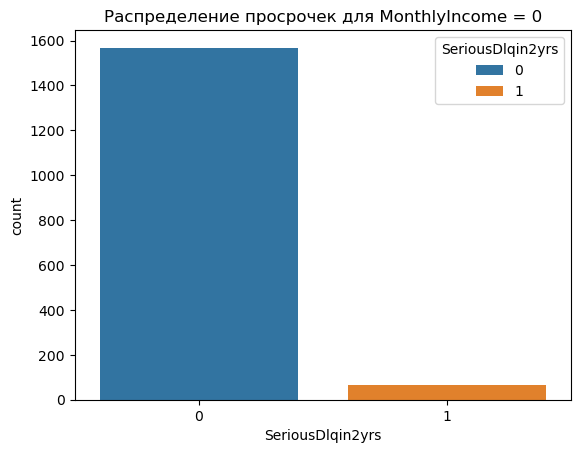

In [15]:
sns.countplot(data=df[df['MonthlyIncome'] == 0], x='SeriousDlqin2yrs', hue='SeriousDlqin2yrs')
plt.title('Распределение просрочек для MonthlyIncome = 0')
plt.show()

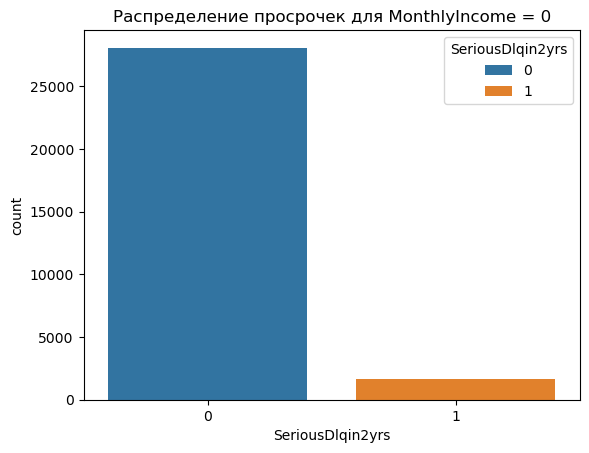

In [16]:
sns.countplot(data=df[df['MonthlyIncome'].isnull()], x='SeriousDlqin2yrs', hue='SeriousDlqin2yrs')
plt.title('Распределение просрочек для MonthlyIncome = 0')
plt.show()

In [17]:

zero_income_default_rate = (df[(df['MonthlyIncome'] == 0) & (df['SeriousDlqin2yrs'] == 1)].shape[0] / 
                            df[df['MonthlyIncome'] == 0].shape[0]) * 100
print('Процент людей с просроченными платежами с нулевым доходом равен', round(zero_income_default_rate, 2), '%')

missing_income_default_rate = (df[(df['MonthlyIncome'].isnull()) & (df['SeriousDlqin2yrs'] == 1)].shape[0] / 
                               df[df['MonthlyIncome'].isnull()].shape[0]) * 100
print('Процент людей с просроченными платежами с пропущенным доходом равен', round(missing_income_default_rate, 2), '%')


Процент людей с просроченными платежами с нулевым доходом равен 4.04 %
Процент людей с просроченными платежами с пропущенным доходом равен 5.61 %


In [18]:
df[df['MonthlyIncome'] == 0][['age', 'DebtRatio', 'NumberOfDependents']].describe()

,age,DebtRatio,NumberOfDependents
count,1634.000000,1634.000000,1634.000000
mean,48.337209,1573.567319,0.730722
std,16.686167,2818.015889,1.186657
min,21.000000,0.000000,0.000000
25%,35.000000,96.000000,0.000000
50%,47.000000,930.000000,0.000000
75%,61.000000,2185.250000,1.000000
max,97.000000,60212.000000,10.000000


In [19]:
df[df['MonthlyIncome'].isnull()][['age', 'DebtRatio', 'NumberOfDependents']].describe()

,age,DebtRatio,NumberOfDependents
count,29731.000000,29731.000000,25807.000000
mean,56.362349,1673.396556,0.316310
std,15.438786,4248.372895,0.809944
min,21.000000,0.000000,0.000000
25%,46.000000,123.000000,0.000000
50%,57.000000,1159.000000,0.000000
75%,67.000000,2382.000000,0.000000
max,109.000000,329664.000000,9.000000


Ключевые наблюдения:
- Люди с нулевым доходом моложе (48 vs 56 лет)
- DebtRatio очень высокий в обеих группах, но медианные значения схожи (930 vs 1159). Однако для группы с NaN встречаются экстремально высокие значения (до 329,664)
- У людей с нулевым доходом больше иждивенцев (в среднем 0.73 против 0.31)

Также проверим влияние пропущенных значений в колонке MonthlyIncome на распределение целевой переменной

In [83]:
df['HasZeroIncome'] = df['MonthlyIncome'] == 0
df['HasMissingIncome'] = df['MonthlyIncome'].isnull()

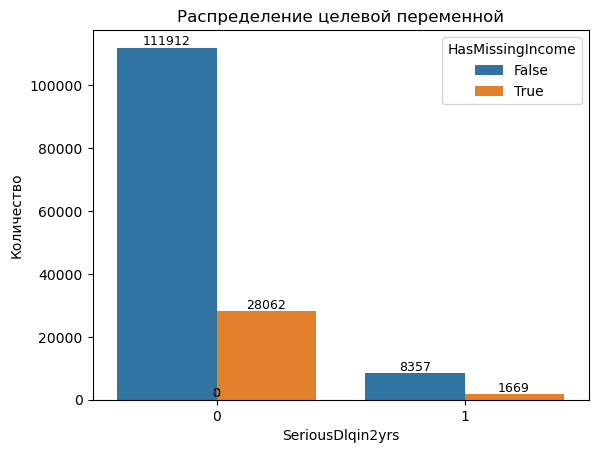

In [22]:
ax = sns.countplot(data=df, x='SeriousDlqin2yrs', hue='HasMissingIncome')
plt.ylabel('Количество')
plt.title('Распределение целевой переменной')

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)    
plt.show()

In [23]:
print('Процент просроченных платежей при MonthlyIncome != Null равно', round(8357 / (8357 + 111912) * 100, 2), '%')
print('Процент просроченных платежей при MonthlyIncome == Null равно', round(1669 / (1669 + 28062) * 100, 2), '%')

Процент просроченных платежей при MonthlyIncome != Null равно 6.95 %
Процент просроченных платежей при MonthlyIncome == Null равно 5.61 %


Разница составляет 1,34%, при этом вероятность просрочки ниже при пропущенном значении MonthlyIncome

Это значит, что пропуски могут быть случайными:
- Пропущзенные значения дохода не связаны с вероятностью просрочки
- Могло произойти из-за ошибок при сборе данных

Проверим статистическую значимость (тест хи-квадрат), чтобы понять, случайна ли эта разница:

In [24]:
zero_income_table = pd.crosstab(df['HasZeroIncome'], df['SeriousDlqin2yrs'])

chi2_zero, p_zero, dof_zero, ex_zero = chi2_contingency(zero_income_table)
print(f'Хи-квадрат (нулевой доход): {chi2_zero}, p-значение: {p_zero}')


missing_income_table = pd.crosstab(df['HasMissingIncome'], df['SeriousDlqin2yrs'])

chi2_missing, p_missing, dof_missing, ex_missing = chi2_contingency(missing_income_table)
print(f'Хи-квадрат (пропущенный доход): {chi2_missing}, p-значение: {p_missing}')

Хи-квадрат (нулевой доход): 18.101093251984228, p-значение: 2.094811214274964e-05
Хи-квадрат (пропущенный доход): 67.89295377039625, p-значение: 1.7261692959788902e-16


Так как в обеих случаях p-value < 0.05, то вероятность случайного возникновения такой разницы крайне мала. Более высокое значение хи-квадрат для пропущенного дохода (67.89) по сравнению с нулевым доходом (18.10) говорит о том, что пропущенные данные имеют более сильную связь с вероятностью просрочки. Признаки HasZeroIncome и HasMissingIncome - информативные признаки

Также добавим эти столбцы в тестовый файл

In [25]:
df_tested['HasZeroIncome'] = df_tested['MonthlyIncome'] == 0
df_tested['HasMissingIncome'] = df_tested['MonthlyIncome'].isnull()

3008750.0


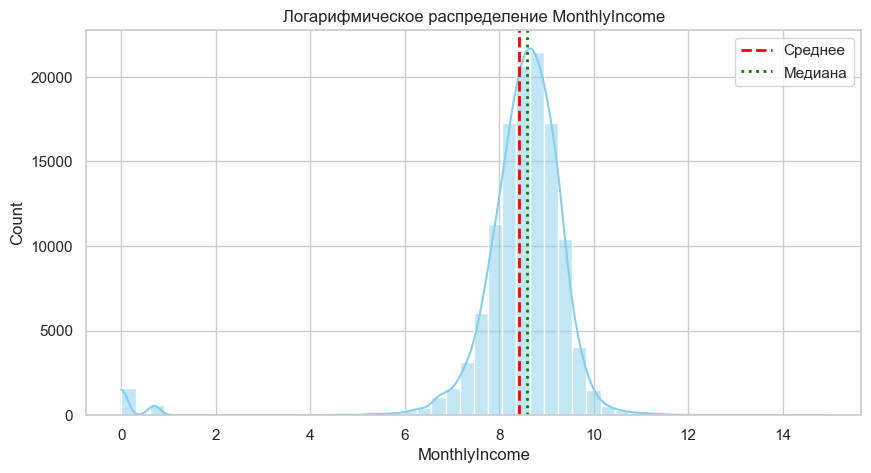

329664.0


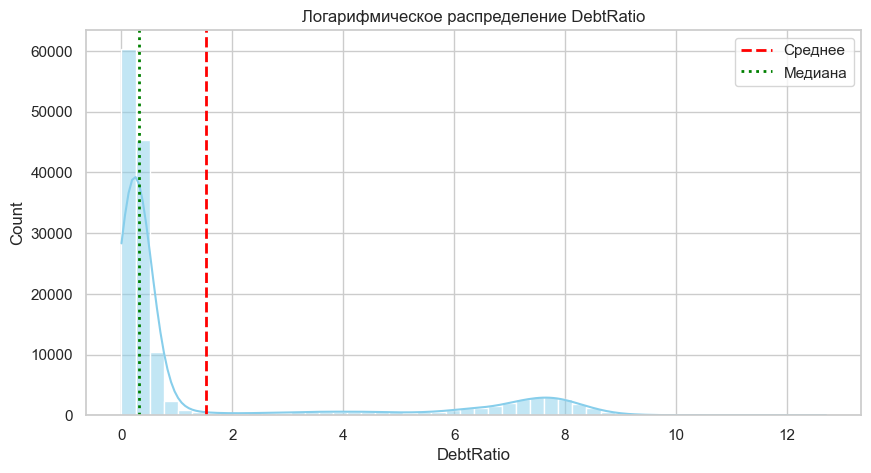

50708.0


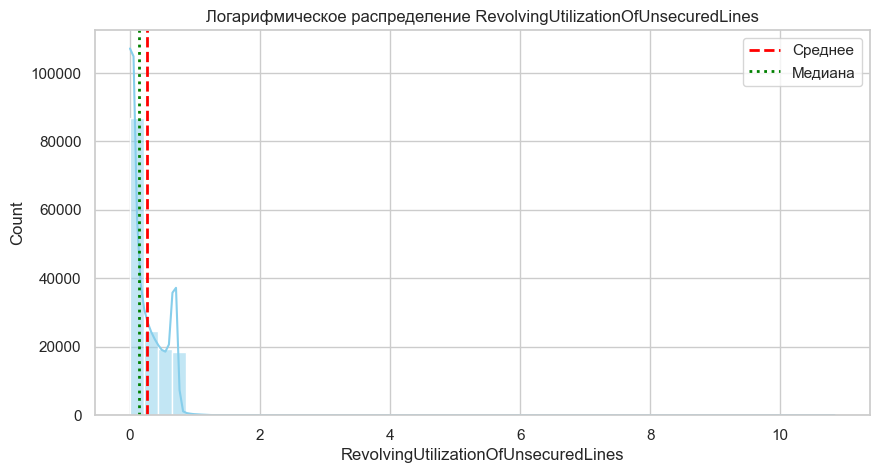

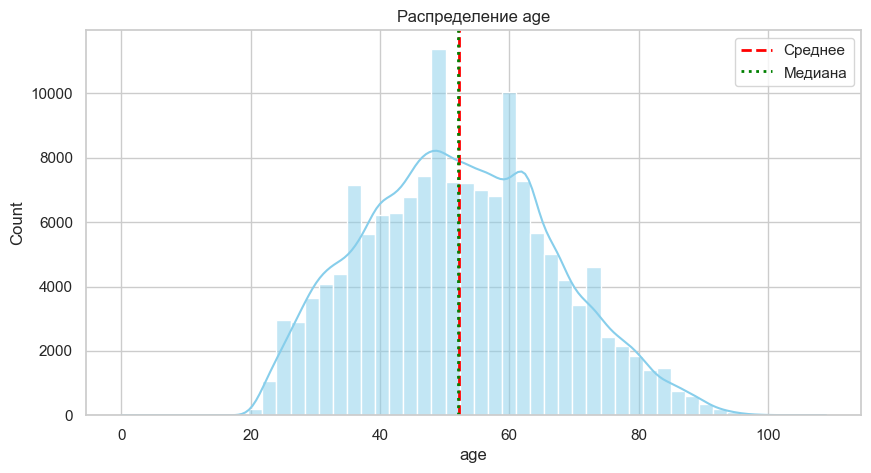

In [ ]:

numeric_features = ['MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'age']

sns.set(style="whitegrid")

for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    
    if df[feature].max() > 10000:
        print(df[feature].max())
        data = np.log1p(df[feature])
        plt.title(f'Логарифмическое распределение {feature}')
    else:
        data = df[feature]
        plt.title(f'Распределение {feature}')
    
    sns.histplot(data, kde=True, bins=50, color='skyblue')
    
    plt.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
    plt.axvline(data.median(), color='green', linestyle='dotted', linewidth=2, label='Медиана')
    
    plt.legend()
    plt.show()


Видно, что некоторые данные распределены ненормально, но так как мы будем обучать xgboost и catboostclassifier, нет необходимости приводить данные к нормальному виду

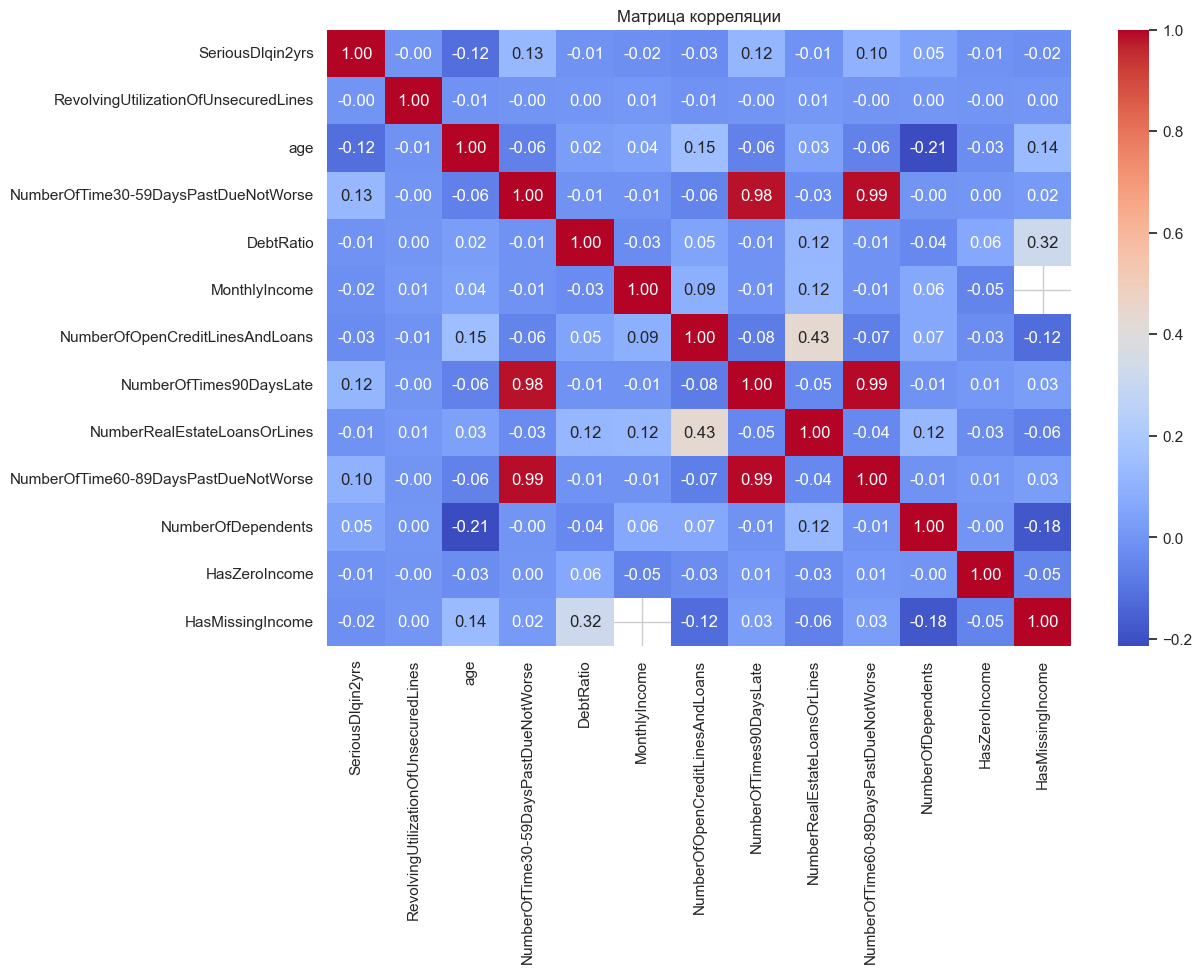

In [27]:
correlation = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()


In [28]:
correlation['SeriousDlqin2yrs'].sort_values(ascending=False)


SeriousDlqin2yrs                        1.000000
NumberOfTime30-59DaysPastDueNotWorse    0.125587
NumberOfTimes90DaysLate                 0.117175
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046048
RevolvingUtilizationOfUnsecuredLines   -0.001802
NumberRealEstateLoansOrLines           -0.007038
DebtRatio                              -0.007602
HasZeroIncome                          -0.011114
MonthlyIncome                          -0.019746
HasMissingIncome                       -0.021308
NumberOfOpenCreditLinesAndLoans        -0.029669
age                                    -0.115386
Name: SeriousDlqin2yrs, dtype: float64

Видно, что некоторые признаки (например, RevolvingUtilizationOfUnsecuredLines, NumberRealEstateLoansOrLines или DebtRatio) практически не коррелируют с целевой переменной

Результаты корреляционного анализа


1. Корреляция с целевой переменной (SeriousDlqin2yrs):

Наибольшая положительная корреляция:
- NumberOfTime30-59DaysPastDueNotWorse (0.13)
- NumberOfTimes90DaysLate (0.12)
- NumberOfTime60-89DaysPastDueNotWorse (0.10)

Отрицательная корреляция:
- age (-0.12) — старшие заёмщики менее склонны к просрочкам.

2. Сильная корреляция между признаками (мультиколлинеарность):
NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse:
Корреляция > 0.98
Это говорит о сильной зависимости между этими признаками, так как все они отражают похожие аспекты кредитной истории.


При обучении модели надо будет рассмотреть возможность исключения одного из них или применения методов регуляризации (например, L1-регуляризация), чтобы уменьшить влияние мультиколлинеарности.

----

Перейдем к нахождению выбросов, воспользуемся IQR

Количество выбросов в MonthlyIncome: 4879


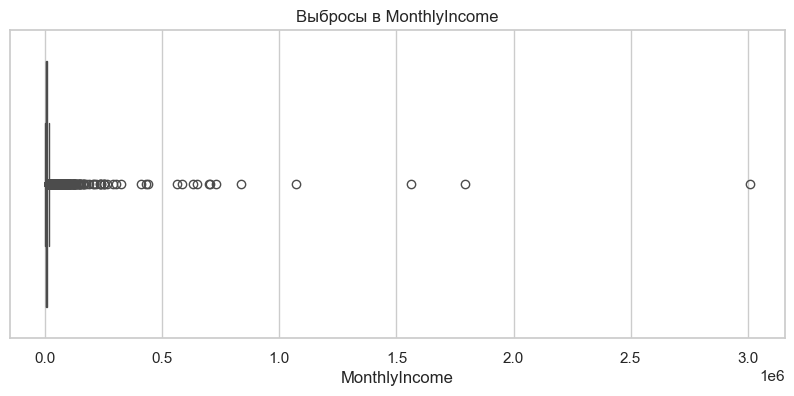

Количество выбросов в DebtRatio: 31311


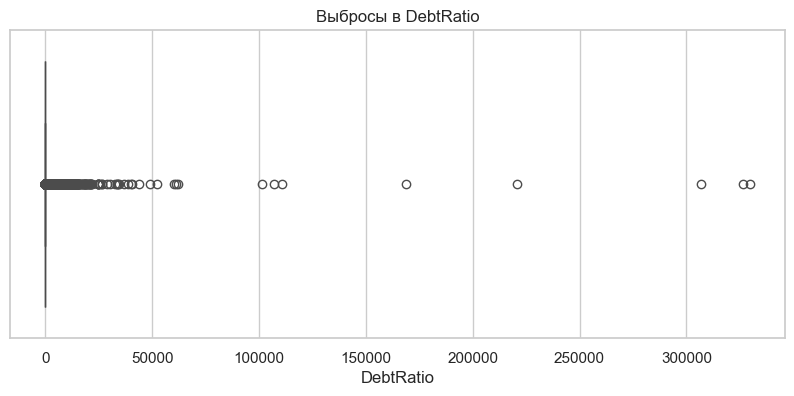

Количество выбросов в RevolvingUtilizationOfUnsecuredLines: 763


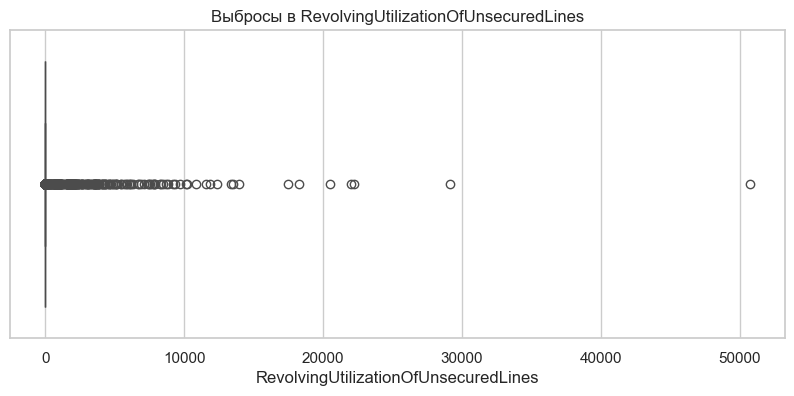

Количество выбросов в age: 46


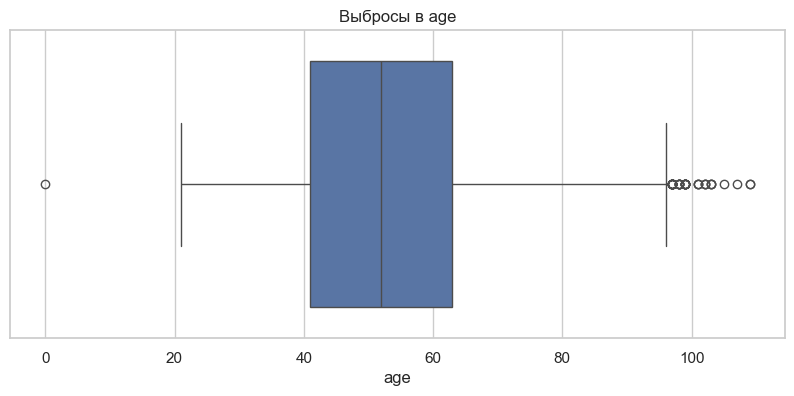

In [ ]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

numeric_features = ['MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'age']

for feature in numeric_features:
    outliers = detect_outliers_iqr(df, feature)
    print(f"Количество выбросов в {feature}: {outliers.shape[0]}")

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'Выбросы в {feature}')
    plt.show()


Так как это финансовые данные, то выбросы могут содержать полезную информацию. В связи с большим количеством выбросов в будущем воспользуемся RobustScaler

----

Перейдем к заполнению пропущенных значений, их мы будем заполнять в Pipeline, чтобы автоматизировать процесс

In [30]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
HasZeroIncome                               0
HasMissingIncome                            0
dtype: int64

В колонке MonthlyIncome нули оставим как есть, а пропущенные значения заполним медианой (для сохранения распределения дохода)

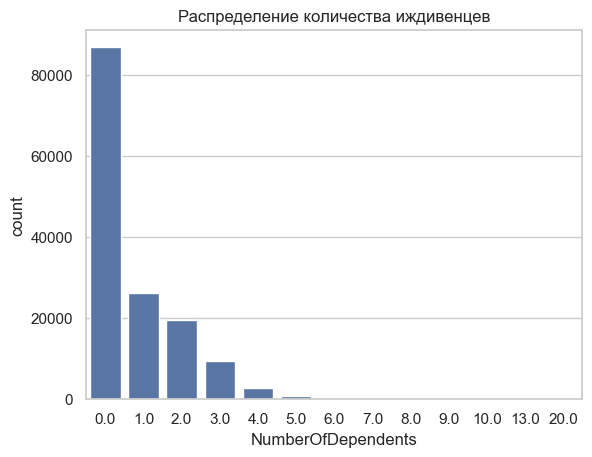

In [31]:
sns.countplot(x='NumberOfDependents', data=df)
plt.title('Распределение количества иждивенцев')
plt.show()


Так как большинство значений равно 0, то заполним пропущенные значения в колонке NumberOfDependents нулями

In [32]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'HasZeroIncome', 'HasMissingIncome'],
      dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
 11  

Также изменим тип данных целевой переменной с int на bool

In [34]:
df['SeriousDlqin2yrs'] = df['SeriousDlqin2yrs'].astype(bool)

In [35]:

income_feature = ['MonthlyIncome']
dependents_feature = ['NumberOfDependents']
numeric_features = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines',
                    'age', 'NumberOfTime30-59DaysPastDueNotWorse',
                    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse']
boolean_features = ['HasMissingIncome', 'HasZeroIncome']

# Пайплайн для MonthlyIncome (заполнение медианой + масштабирование)
income_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Пайплайн для NumberOfDependents (заполнение нулями + масштабирование)
dependents_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler())
])

# Пайплайн для остальных числовых признаков (только масштабирование)
numeric_pipeline = Pipeline([
    ('scaler', RobustScaler())
])

bool_pipeline = Pipeline([
    ('passthrough', 'passthrough')
])

preprocessor = ColumnTransformer([
    ('income', income_pipeline, income_feature),
    ('dependents', dependents_pipeline, dependents_feature),
    ('num', numeric_pipeline, numeric_features),
    ('bool', bool_pipeline, boolean_features)
])


----

Разделим данные на тестовую и тренировочную выборки и добавим модели машинного обучения непосредственно в пайплайн

In [86]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Так как у нас классы не сбалансированны, то небходимо использовать подходы к учету дисбаланса классов

1. Использование параметра class_weight='balanced' в моделях:автоматически учитывает дисбаланс классов, присваивая вес, обратный частоте каждого класса.
2. Использование методов ресэмплинга:
- Oversampling (например, SMOTE): добавление синтетических примеров для миноритарного класса.
- Undersampling: уменьшение количества примеров мажоритарного класса.
3. Оптимизация метрик чувствительных к дисбалансу: вместо точности можно использовать F1-score, ROC-AUC и другие метрики.

Сначала попробуем воспользоваться class_weight, а дальше при необходимости воспользуемся SMOTE

Начнем с логистической регрессии

In [38]:
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000000, solver='liblinear', class_weight='balanced', random_state=42))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],     
    'classifier__penalty': ['l1', 'l2'],            
}

logistic_grid_search = GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

logistic_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('income',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['MonthlyIncome']),
                                                                        ('dependents',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['NumberOfDependents']...
                                                                          'NumberOfTime60-89DaysPastDueNotWorse']),
                                                                        ('bool',
                                                                         Pipeline(steps=[('passthrough',
                                                                                          'passthrough')]),
                                                                         ['HasMissingIncome',
                                                                          'HasZeroIncome'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=2)

In [39]:
logistic_predict = logistic_grid_search.predict(X_test)
logistic_predict_proba = logistic_grid_search.predict_proba(X_test)[:, 1]
print("Лучшие параметры:", logistic_grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, logistic_predict))
print(f"\nROC-AUC: {roc_auc_score(y_test, logistic_predict_proba):.4f}")

Лучшие параметры: {'classifier__C': 0.001, 'classifier__penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.78      0.86     27995
        True       0.18      0.67      0.28      2005

    accuracy                           0.77     30000
   macro avg       0.58      0.73      0.57     30000
weighted avg       0.92      0.77      0.83     30000


ROC-AUC: 0.8030


Будем сохранять лучшие результаты моделей в датафрейм

In [40]:
results_df = pd.DataFrame(columns=['Model', 'Best Params', 'Accuracy', 'F1 Score', 'ROC-AUC'])

In [41]:
accuracy = accuracy_score(y_test, logistic_predict)
f1 = f1_score(y_test, logistic_predict)
roc_auc = roc_auc_score(y_test, logistic_predict_proba)
best_params = logistic_grid_search.best_params_


results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Best Params': [best_params],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'ROC-AUC': [roc_auc]
})], ignore_index=True)


LogisticRegression будет являться в качестве baseline. Напишем пайплайн, который обучает несколько моделей c использованием GridSearchCV, и сохраняет метрики в results_df для удобного сравнения 

In [ ]:
# Расчет scale_pos_weight
pos_count = np.sum(y_train == 1)
neg_count = np.sum(y_train == 0)
scale_pos_weight = neg_count / pos_count

models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [5, 10, 12, None],
            'classifier__class_weight': [None, 'balanced']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [6, 10],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5]
        }
    },
       'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'classifier__iterations': [100, 200],
            'classifier__depth': [4, 6, 8, 10],
            'classifier__learning_rate': [0.005, 0.01, 0.1],
            'classifier__scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5]
        }
    }
}


for model_name, model_info in models.items():
    print(f"Обучение модели: {model_name}")

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model_info['model'])
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=model_info['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.predict(X_test)
    y_proba = grid_search.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    best_params = grid_search.best_params_
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': [model_name],
        'Best Params': [best_params],
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'ROC-AUC': [roc_auc]
    })], ignore_index=True)



Обучение модели: Random Forest
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Обучение модели: XGBoost
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Обучение модели: CatBoost
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [46]:
results_df

,Model,Best Params,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,"{'classifier__C': 0.001, 'classifier__penalty'...",0.772667,0.283463,0.802986
1,Random Forest,"{'classifier__class_weight': None, 'classifier...",0.937133,0.255134,0.868659
2,XGBoost,"{'classifier__learning_rate': 0.1, 'classifier...",0.937367,0.292811,0.867400
3,CatBoost,"{'classifier__depth': 10, 'classifier__iterati...",0.938067,0.292460,0.869372


Cледующие шаги:
1. Добавить SMOTE для балансировки классов.
2. Протестировать ансамбль из XGBoost и CatBoost.
3. Проанализировать улучшения и сравнить с текущими результатами.

В пайплайн добавим SMOTE для балансировки классов и воспользуемся лучшей моделью, найденной при помощи GridSearch

In [ ]:
best_model = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1, scale_pos_weight=1)

pipeline_smote = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_model)
])

pipeline_smote.fit(X_train, y_train)

y_pred_smote = pipeline_smote.predict(X_test)
y_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]

accuracy_smote = accuracy_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)
best_params_smote = pipeline_smote['classifier'].get_params()

results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['catboost+smote'],
    'Best Params': [best_params_smote],
    'Accuracy': [accuracy_smote],
    'F1 Score': [f1_smote],
    'ROC-AUC': [roc_auc_smote]
})], ignore_index=True)

0:	learn: 0.6292433	total: 30.4ms	remaining: 3.01s
1:	learn: 0.5769598	total: 55.3ms	remaining: 2.71s
2:	learn: 0.5323218	total: 94.2ms	remaining: 3.05s
3:	learn: 0.4954853	total: 135ms	remaining: 3.24s
4:	learn: 0.4646178	total: 167ms	remaining: 3.17s
5:	learn: 0.4369982	total: 192ms	remaining: 3.01s
6:	learn: 0.4137711	total: 219ms	remaining: 2.91s
7:	learn: 0.3930580	total: 244ms	remaining: 2.8s
8:	learn: 0.3739771	total: 269ms	remaining: 2.72s
9:	learn: 0.3576948	total: 294ms	remaining: 2.65s
10:	learn: 0.3440173	total: 319ms	remaining: 2.58s
11:	learn: 0.3319055	total: 344ms	remaining: 2.52s
12:	learn: 0.3211846	total: 369ms	remaining: 2.47s
13:	learn: 0.3114474	total: 395ms	remaining: 2.42s
14:	learn: 0.3033554	total: 421ms	remaining: 2.39s
15:	learn: 0.2961789	total: 447ms	remaining: 2.35s
16:	learn: 0.2885097	total: 473ms	remaining: 2.31s
17:	learn: 0.2824917	total: 502ms	remaining: 2.29s
18:	learn: 0.2771021	total: 529ms	remaining: 2.25s
19:	learn: 0.2711519	total: 554ms	remai

In [70]:
results_df

,Model,Best Params,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,"{'classifier__C': 0.001, 'classifier__penalty'...",0.772667,0.283463,0.802986
1,Random Forest,"{'classifier__class_weight': None, 'classifier...",0.937133,0.255134,0.868659
2,XGBoost,"{'classifier__learning_rate': 0.1, 'classifier...",0.937367,0.292811,0.867400
3,CatBoost,"{'classifier__depth': 10, 'classifier__iterati...",0.938067,0.292460,0.869372
4,catboost+smote,"{'iterations': 100, 'learning_rate': 0.1, 'dep...",0.908567,0.426990,0.859563


Модель показала результаты хуже

Также попробуем ансамблирование моделей (stacking). В качестве моделей возьмем xgb и catboost с лучшими параметрами, найденными при помощи gridsearch

In [71]:
xgb_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1}
cat_params = {'depth': 10, 'iterations': 100, 'learning_rate': 0.1, 'scale_pos_weight': 1}
xgb_model = XGBClassifier(**xgb_params)
cat_model = CatBoostClassifier(**cat_params)

stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

pipeline_stacking = Pipeline([
    ('preprocessing', preprocessor),
    ('stacking', stacking_model)
])

pipeline_stacking.fit(X_train, y_train)
y_pred_stacking = pipeline_stacking.predict(X_test)
y_proba_stacking = pipeline_stacking.predict_proba(X_test)[:, 1]

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, y_proba_stacking)
best_params_stacking = pipeline_stacking['stacking'].get_params()

results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['Stacking_model'],
    'Best Params': [best_params_stacking],
    'Accuracy': [accuracy_stacking],
    'F1 Score': [f1_stacking],
    'ROC-AUC': [roc_auc_stacking]
})], ignore_index=True)

0:	learn: 0.6175561	total: 18.3ms	remaining: 1.81s
1:	learn: 0.5556534	total: 36.3ms	remaining: 1.78s
2:	learn: 0.5043399	total: 54ms	remaining: 1.75s
3:	learn: 0.4611805	total: 69.4ms	remaining: 1.66s
4:	learn: 0.4245997	total: 84.1ms	remaining: 1.6s
5:	learn: 0.3932690	total: 98.6ms	remaining: 1.54s
6:	learn: 0.3660206	total: 114ms	remaining: 1.51s
7:	learn: 0.3427797	total: 127ms	remaining: 1.47s
8:	learn: 0.3223974	total: 142ms	remaining: 1.43s
9:	learn: 0.3048215	total: 156ms	remaining: 1.4s
10:	learn: 0.2893482	total: 171ms	remaining: 1.39s
11:	learn: 0.2756901	total: 186ms	remaining: 1.37s
12:	learn: 0.2639188	total: 202ms	remaining: 1.35s
13:	learn: 0.2534960	total: 216ms	remaining: 1.33s
14:	learn: 0.2442883	total: 231ms	remaining: 1.31s
15:	learn: 0.2363044	total: 246ms	remaining: 1.29s
16:	learn: 0.2294033	total: 262ms	remaining: 1.28s
17:	learn: 0.2234114	total: 277ms	remaining: 1.26s
18:	learn: 0.2178414	total: 292ms	remaining: 1.24s
19:	learn: 0.2128565	total: 307ms	remai

In [122]:
results_df

,Model,Best Params,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,"{'classifier__C': 0.001, 'classifier__penalty'...",0.772667,0.283463,0.802986
1,Random Forest,"{'classifier__class_weight': None, 'classifier...",0.937133,0.255134,0.868659
2,XGBoost,"{'classifier__learning_rate': 0.1, 'classifier...",0.937367,0.292811,0.867400
3,CatBoost,"{'classifier__depth': 10, 'classifier__iterati...",0.938067,0.292460,0.869372
4,catboost+smote,"{'iterations': 100, 'learning_rate': 0.1, 'dep...",0.908567,0.426990,0.859563
5,Stacking_model,"{'cv': 5, 'estimators': [('xgb', XGBClassifier...",0.938233,0.334650,0.869916


Stacking model лучше по всем параметрам

Оценим важность признаков

<Axes: xlabel='Feature'>

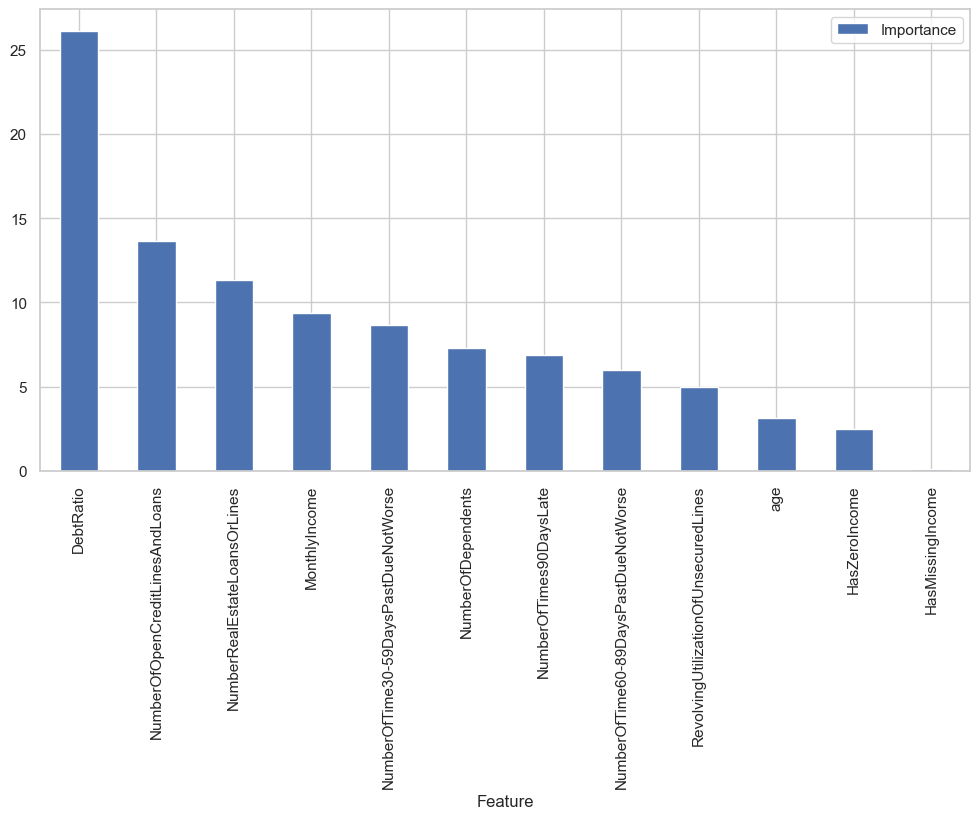

In [81]:
feature_importances = pipeline_stacking.named_steps['stacking'].named_estimators_['cat'].get_feature_importance()
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False).plot(kind='bar', x='Feature', figsize=(12, 6))

Видно, что признак HasMissingIncome практически не влияет на целевую переменную. Попробуем удалить его

In [ ]:
def check_new_variant(X, y):
    X = X.drop('HasMissingIncome', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    income_feature = ['MonthlyIncome']
    dependents_feature = ['NumberOfDependents']
    numeric_features = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines',
                        'age', 'NumberOfTime30-59DaysPastDueNotWorse',
                        'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                        'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse']
    boolean_features = ['HasZeroIncome']

    income_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    dependents_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', RobustScaler())
    ])

    numeric_pipeline = Pipeline([
        ('scaler', RobustScaler())
    ])

    bool_pipeline = Pipeline([
        ('passthrough', 'passthrough')
    ])

    preprocessor = ColumnTransformer([
        ('income', income_pipeline, income_feature),
        ('dependents', dependents_pipeline, dependents_feature),
        ('num', numeric_pipeline, numeric_features),
        ('bool', bool_pipeline, boolean_features)
    ])
    xgb_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1}
    cat_params = {'depth': 10, 'iterations': 100, 'learning_rate': 0.1, 'scale_pos_weight': 1}
    xgb_model = XGBClassifier(**xgb_params)
    cat_model = CatBoostClassifier(**cat_params)

    stacking_model = StackingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('cat', cat_model)
        ],
        final_estimator=LogisticRegression(),
        cv=5
    )

    pipeline_stacking = Pipeline([
        ('preprocessing', preprocessor),
        ('stacking', stacking_model)
    ])

    pipeline_stacking.fit(X_train, y_train)
    y_pred_stacking = pipeline_stacking.predict(X_test)
    y_proba_stacking = pipeline_stacking.predict_proba(X_test)[:, 1]

    accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
    f1_stacking = f1_score(y_test, y_pred_stacking)
    roc_auc_stacking = roc_auc_score(y_test, y_proba_stacking)
    best_params_stacking = pipeline_stacking['stacking'].get_params()

    print(accuracy_stacking, 'accuracy')
    print(f1_stacking, 'f1-score')
    print(roc_auc_stacking, 'roc_auc')
    print(best_params_stacking, 'best_params')

In [87]:
check_new_variant(X, y)

0:	learn: 0.6183095	total: 18.6ms	remaining: 1.84s
1:	learn: 0.5568691	total: 23.9ms	remaining: 1.17s
2:	learn: 0.5051647	total: 39.7ms	remaining: 1.28s
3:	learn: 0.4615999	total: 56.2ms	remaining: 1.35s
4:	learn: 0.4246659	total: 70.7ms	remaining: 1.34s
5:	learn: 0.3933457	total: 85.4ms	remaining: 1.34s
6:	learn: 0.3662067	total: 100ms	remaining: 1.33s
7:	learn: 0.3428884	total: 115ms	remaining: 1.32s
8:	learn: 0.3225953	total: 129ms	remaining: 1.31s
9:	learn: 0.3049628	total: 144ms	remaining: 1.29s
10:	learn: 0.2895568	total: 158ms	remaining: 1.28s
11:	learn: 0.2760288	total: 173ms	remaining: 1.27s
12:	learn: 0.2641889	total: 188ms	remaining: 1.26s
13:	learn: 0.2539161	total: 203ms	remaining: 1.24s
14:	learn: 0.2452824	total: 218ms	remaining: 1.24s
15:	learn: 0.2373509	total: 233ms	remaining: 1.22s
16:	learn: 0.2299900	total: 249ms	remaining: 1.21s
17:	learn: 0.2235480	total: 265ms	remaining: 1.21s
18:	learn: 0.2180733	total: 280ms	remaining: 1.19s
19:	learn: 0.2132936	total: 296ms	r

Метрики стали чуть хуже, поэтому убирать данный признак не будем

Оценка и анализ лучшей модели - stacking_model

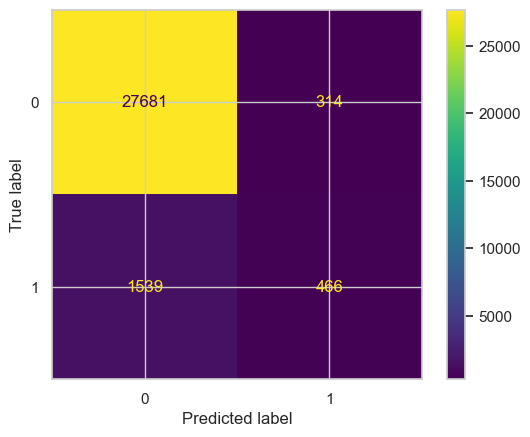

In [ ]:

cm = confusion_matrix(y_test, y_pred_stacking)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

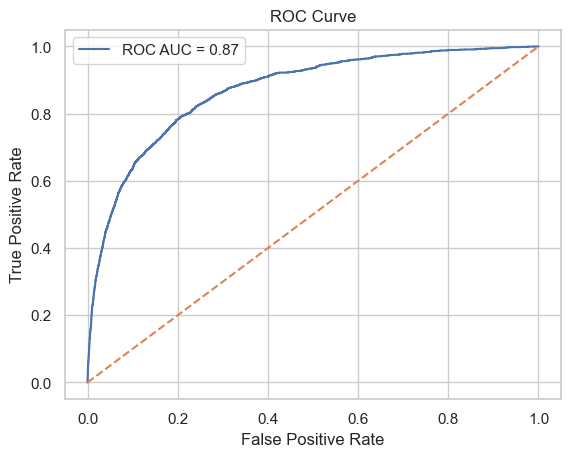

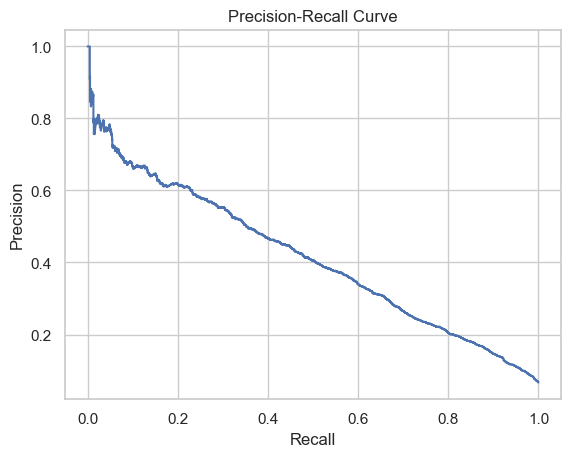

In [ ]:


# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba_stacking)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test, y_proba_stacking)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
results_df.to_csv('models_scores.csv')

Сделаем предсказания на тестовом наборе данных и отправим на Kaggle

In [104]:
df_tested.drop('Unnamed: 0', inplace=True, axis = 1)
df_tested.drop('SeriousDlqin2yrs', inplace=True, axis=1)


In [106]:
df_tested.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,HasZeroIncome,HasMissingIncome
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,False,False
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,False,False
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,False,False
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,False,False
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,False,False


In [107]:
df_tested.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 1   age                                   101503 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 3   DebtRatio                             101503 non-null  float64
 4   MonthlyIncome                         81400 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 6   NumberOfTimes90DaysLate               101503 non-null  int64  
 7   NumberRealEstateLoansOrLines          101503 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 9   NumberOfDependents                    98877 non-null   float64
 10  HasZeroIncome                         101503 non-null  bool   
 11  

In [108]:
test_predictions = pipeline_stacking.predict_proba(df_tested)[:, 1]

In [120]:
sample_entry = pd.read_csv('sampleEntry.csv')
sample_entry['Probability'] = test_predictions

In [121]:
sample_entry.to_csv('for_kaggle.csv', index=False)

Получили результат

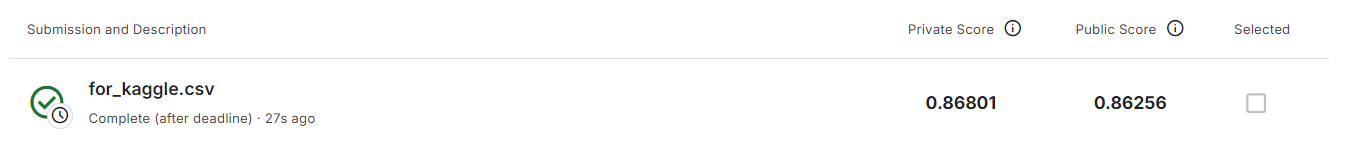

Загрузим лучшую модель

In [ ]:
joblib.dump(pipeline_stacking['stacking'], 'models/best_stacking_model.pkl')


['best_stacking_model.pkl']

In [135]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'HasZeroIncome', 'HasMissingIncome'],
      dtype='object')

Итак, лучшей моделью оказалась модель StackingClassifier с комбинацией моделей XGBoost ({'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1}) и CatBoostClassifier ({'depth': 10, 'iterations': 100, 'learning_rate': 0.1, 'scale_pos_weight': 1})

Результаты модели:
- Accuracy = 0.938
- F1-score = 0.334
- ROC-AUC = 0.869
